# TODO

- lineage? YES --> spin up polymorphism scoring from BAMs (pretty complex problem)
- SCPs require contact with nerves: 
https://www.cell.com/cell/fulltext/S0092-8674(09)01043-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867409010435%3Fshowall%3Dtrue
- find marker genes of hair follicle melanocytes

CREATE JUP NOTEBOOK AND SHARE


May 27 - Apr 3

ADD IMAGES TO DRIVE FOLDER
    - emailed on May 30
    
2) Would it make sense/be possible to redo the correlation tests but instead of comparing the whole transcriptome profile of the direct and indirect melanocytes, only compare based on a subsetted gene list of what genes are enriched in each pathway or the genes that are driving the first principal component or something like that? Would that give a better picture of "this is what is unique about the indirect melanocytes compared to the direct melanocytes, and these factors that make the indirect melanocytes unique are more correlated to primary/cancer"
    - correlations using only marker genes does not change correlations


May 20-26

1) When looking at the correlations of each cell type to the melanoma lines, would it be possible to get the gene lists for what is driving the correlation that is there so that we can identify the genes present in the indirect melanocytes that make them more correlated than the direct melanocytes?
    - implemented 3-way linear regression and analysis of residuals
    - can now prioritize genes on both dir vs indir and dish vs cancer
    - linear model poorly describes the expression correlation between dish MELs and cancer

3) For the heat maps (in the first two slides of what you sent) add glial genes (CD44, S100B, CAV1, PMP22, MBP) this might help with showing that the "bi-potent progenitor" isn't just this weird almost melanocyte thing but more of a weird in-between melanocyte/glia thing, while also showing that these glial genes are never present in the direct lineage.
    - implemented new genes
    - looks like most marker genes look like melanoblasty


# Setup

In [1]:
wkdir, s3dir = '/home/ubuntu/data/DL20190312_dish_mel', 'daniel.le-work/dish_MEL'
%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
from collections import defaultdict
import multiprocessing, glob
from sklearn.preprocessing import scale, MinMaxScaler
sc.settings.figdir = '/home/ubuntu/data/DL20190312_dish_mel/plot/'


# import data from s3
for file in ['adata_all']:
# for file in ['adata_unproc', 'COI_names']:
        
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var
    gc.collect()


/home/ubuntu/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


scanpy version: 1.4.2


In [2]:
# FUNCTIONS
def min_max_scaler(x):
    scaler = MinMaxScaler()
    scaler.fit(x.reshape((-1,1)))
    return scaler.transform(x.reshape((-1,1))).reshape((-1,))

def single_mwu(args):    
    # inputs
    gene_val, df1, df2, alt = args
    
    try:
        stat, pval = stats.mannwhitneyu(df1[gene_val].values,
                                        df2[gene_val].values, 
                                        alternative = alt
                                       )
    except:
        stat = np.nan
        pval = np.nan
    return (stat, pval)

def parallel_mwu(genes, df1, df2, method='two-sided', ncores=1):
    
    p = multiprocessing.Pool(processes=ncores)
    try:
        mwu_tuples = p.map(single_mwu, 
                                zip(genes,
                                    [df1]*len(genes),
                                    [df2]*len(genes),
                                    [method]*len(genes)
                                   ), 
                                chunksize=100)
    finally:
        p.close()
        p.join()

    stat_list = [x[0] for x in mwu_tuples]
    pval_list = [x[1] for x in mwu_tuples]
    return (stat_list, pval_list)

def disp_analysis(adata, min_mean=None, max_mean=None, min_disp=None):
    
    print('Process expression data...')
    print('\tInitial:')
    sum_output(adata)
    
    tmp = sc.pp.normalize_per_cell(adata, copy=True)
    filter_result = sc.pp.filter_genes_dispersion(tmp.X, 
                                                  min_mean=min_mean, 
                                                  max_mean=max_mean, 
                                                  min_disp=min_disp)
    tmp = tmp[:, filter_result.gene_subset]
    
    print('Filtered cells: {}'.format(len(adata.obs) - len(tmp.obs)))
    print('Filtered genes: {}'.format(len(adata.var_names) - len(tmp.var_names)))
    print('\tResult:')
    sum_output (tmp)
    
    return tmp

## Ingest data

In [3]:
run_me = False

if run_me == True:

    raw_dir = '/home/ubuntu/data/DL20190312_dish_mel/raw_dish_allcells'
    out_dir = '/home/ubuntu/data/DL20190312_dish_mel/'
    for idx, subdir in enumerate(glob.glob(f'{raw_dir}/*/')):
        # extract metadata
        meta_str = subdir.split('/')[-2].split('_')
        path = meta_str[0]
        if path == 'dir':
            path = 'direct'
        elif path == 'indir':
            path = 'indirect'
        day = int(meta_str[1][1:])

        print(path, day)

        # compile expression data
        adata_slice = sc.read_10x_mtx(subdir)
        sc.pp.filter_cells(adata_slice, min_genes=500)
        sc.pp.filter_cells(adata_slice, min_counts = 1000)
        adata_slice.obs['path'] = path
        adata_slice.obs['day'] = day

        if idx == 0:
            adata_all = adata_slice 
        else:
            adata_all = adata_all.concatenate(adata_slice, join='outer')

    # remove ERCC counts
    adata_all = adata_all[:, [x for x in adata_all.var_names if not x.startswith('ERCC-')]]

    # update categorical path
    adata_all.obs['path'] = (adata_all
                             .obs['path']
                             .astype(str)
                             .astype(CategoricalDtype(['indirect','direct','trunk']))
                            )

    # log transform
    adata_all.raw = sc.pp.log1p(adata_all, copy=True) # freeze raw state

    # pickle adatas
    for objname in ['adata_all']:
        pickle.dump(eval(objname), open( f'{out_dir}/{objname}.p', 'wb' ), protocol=4)
        syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
        subprocess.run(syscmd.split(' '))


In [ ]:
# pca and umap optimization
n_pcs = 75

all_cells_adata = sc.pp.log1p(adata_all, copy=True) # new
sc.pp.highly_variable_genes(all_cells_adata,min_mean=0.1,max_mean=10,min_disp=0.5) # new
sc.pp.scale(all_cells_adata) # new
sc.tl.pca(all_cells_adata, use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
sc.pp.neighbors(all_cells_adata, n_pcs=n_pcs, n_neighbors = 15, random_state=1) # new
sc.tl.umap(all_cells_adata, min_dist = 0.5, random_state=1)
sc.tl.louvain(all_cells_adata, resolution = 1, random_state=1)

sc.pl.umap(all_cells_adata, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral', )
#            save = 'plot_1.svg')


## Module scoring for annotations


In [ ]:
run_me = True
input_adata = all_cells_adata

if run_me == True:
    
    cycling_module = ['TOP2A','CDK1','UBE2C',
                      'HIST1H4E','HIST1H4C'] # ref: https://www.biorxiv.org/content/biorxiv/early/2019/02/03/526848.full.pdf
    CNS_neuronal_precursors = ['SIX3','PAX6','FEZF1',
                               'DLK1','HESX1','LHX5',
                               'LMO1','EMX2','ARX']
    ESC = ['DNMT3B','NANOG','POU5F1','SOX2']
    low_quality = ['ACTB','GAPDH','RPL7','RPS27A']
    neural_crest_precursors = ['SOX10','FOXD3','WNT1',
                               'SNAI2','SOX9','PAX3']
    ectoderm_fibroblast = ['GATA3','EPCAM','KRT18',
                           'KRT19','CD9','CLDN6']
    trigeminal_placode_ganglia = ['SST','ISL1','SIX1',
                                  'POU4F1','NEFM']
    cranial_placode = ['PAX6','BMP4','RBFOX1','CD82']
    CNS_precursors = ['FRZB','NEFM','MSX1','MSX2','CDH11']
    schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']

    genesOI = list(set(cycling_module + CNS_neuronal_precursors + ESC + low_quality + neural_crest_precursors +
                                    ectoderm_fibroblast + trigeminal_placode_ganglia + cranial_placode + CNS_precursors + schwann))
    print('missing genes:', [x for x in genesOI if x not in input_adata.var_names])

    input_adata.obs['cell'] = input_adata.obs.index.tolist()
    input_adata.obs['cell'] = (input_adata
                              .obs['cell']
                              .astype(str)
                              .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
    cat, exp_df = prepare_dataframe(input_adata,
                     var_names = genesOI,
                     groupby = 'cell')
    exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
    exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene
    input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
    input_adata.obs['CNS_neuronal_precursors'] = exp_df.loc[:,CNS_neuronal_precursors].mean(axis=1)
    input_adata.obs['ESC'] = exp_df.loc[:,ESC].mean(axis=1)
    input_adata.obs['low_quality'] = exp_df.loc[:,low_quality].mean(axis=1)
    input_adata.obs['neural_crest_precursors'] = exp_df.loc[:,neural_crest_precursors].mean(axis=1)
    input_adata.obs['ectoderm_fibroblast'] = exp_df.loc[:,ectoderm_fibroblast].mean(axis=1)
    input_adata.obs['trigeminal_placode_ganglia'] = exp_df.loc[:,trigeminal_placode_ganglia].mean(axis=1)
    input_adata.obs['cranial_placode'] = exp_df.loc[:,cranial_placode].mean(axis=1)
    input_adata.obs['CNS_precursors'] = exp_df.loc[:,CNS_precursors].mean(axis=1)
    input_adata.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1)
    
    targets = ['cycling_score', 'CNS_neuronal_precursors', 'ESC', 
               'low_quality','neural_crest_precursors','ectoderm_fibroblast',
               'trigeminal_placode_ganglia', 'cranial_placode', 'CNS_precursors','schwann'
              ]
    
#     clusters
    sc.pl.umap(input_adata, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral', )
#            save = 'plot_2.svg')
    
#     module scores
    sc.pl.umap(input_adata, color = targets, cmap = 'nipy_spectral', ncols = 2, )
#            save = 'plot_3.svg')
    
#     quality metrics
    sc.pl.umap(input_adata, color = ['n_counts','n_genes'], 
               cmap = 'nipy_spectral', ncols = 2,)
#               save = 'plot_4.svg')


In [ ]:
run_me = True
save_results = False
input_adata = all_cells_adata

if run_me == True: 
    
    # manual annotations

    ## create dictionary
    cluster2anno = {'3':'ESC_COI', # ESC
                    '2':'neural_crest_precursors_COI', # neural crest
                    '11':'trigeminal_placode_ganglia', # indir_d15
                    '19':'ectoderm_fibroblast',
                    '14':'cranial_placode', # indir_d22
                    '4':'indir_branchpoint_COI', # indir_d15-30
                    '15':'indir_branchpoint_COI',
                    '17':'indir_branchpoint_COI',
                    '21':'indir_branchpoint_COI',
                    '6':'indir_d41_COI', # indir_d41
                    '16':'indir_d41_COI', # indir_d41
                    '1':'indir_d50_59_COI', # indir_d50-59
                    '7':'indir_d50_59_COI',
                    '10':'dir_branchpoint_COI', # dir_d15
                    '0':'dir_d22_COI', # dir_d22
                    '12':'dir_d30_COI', # dir_d30
                    '5':'dir_d30_COI',
                   }

    ### update dict with unknown cluster label
    for x in [x for x in set(input_adata.obs.louvain) if x not in [key for key,value in cluster2anno.items()]]:
        cluster2anno[x] = f'low_quality_{x}'

    input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster2anno)
    sc.pl.umap(input_adata, color = ['annotation'], palette = 'tab20',)
#               save = 'plot_5.svg')

    ## add COI bool label
    input_adata.obs['COI'] = [x.endswith('_COI') for x in input_adata.obs['annotation']]
    input_adata.obs['COI'] = input_adata.obs['COI'].astype(str)
    sc.pl.umap(input_adata, color = ['COI','day','path','louvain'], palette = 'tab20', ncols =2,)
#               save = 'plot_6.svg')

    ## save and push
    adata_coi = input_adata[input_adata.obs.COI == 'True']
    COI_names = adata_coi.obs_names.values.tolist()
    
    # pickle adatas
    if save_results == True:
        
        for objname in ['COI_names']:
            pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ), protocol=4 )
            syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
            subprocess.run(syscmd.split(' '))
    

# subet to COI

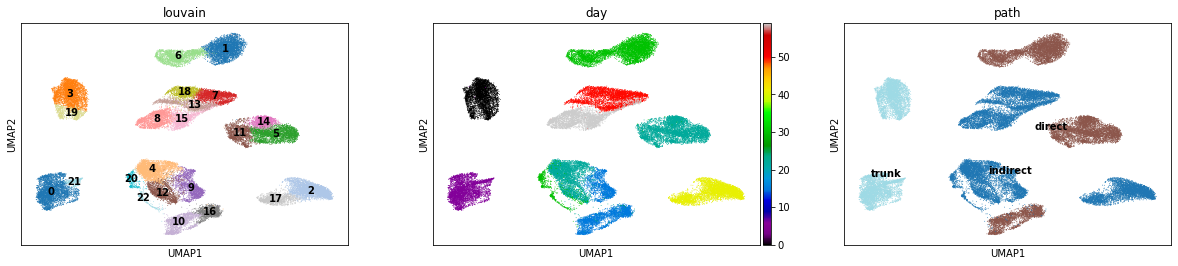

In [7]:
run_me = True
input_adata = all_cells_adata
coi_idx = input_adata[input_adata.obs['COI'] == 'True'].obs.index.tolist()

if run_me == True:    
    # UMAP and PCA
    # pca and umap optimization
    n_pcs = 150
    adata_coi = sc.pp.log1p(adata_all[[x in coi_idx for x in adata_all.obs.index]], copy=True) # new
    sc.pp.highly_variable_genes(adata_coi,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(adata_coi) # new
    sc.tl.pca(adata_coi, use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
    sc.pp.neighbors(adata_coi, n_pcs=n_pcs, n_neighbors = 20, random_state=1) # new
    sc.tl.umap(adata_coi, min_dist = 0.5, random_state=1)
    sc.tl.louvain(adata_coi, resolution = 1.7, random_state=1)
    sc.pl.umap(adata_coi, color = ['louvain','day','path'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral',)
# save = 'plot_7.svg')


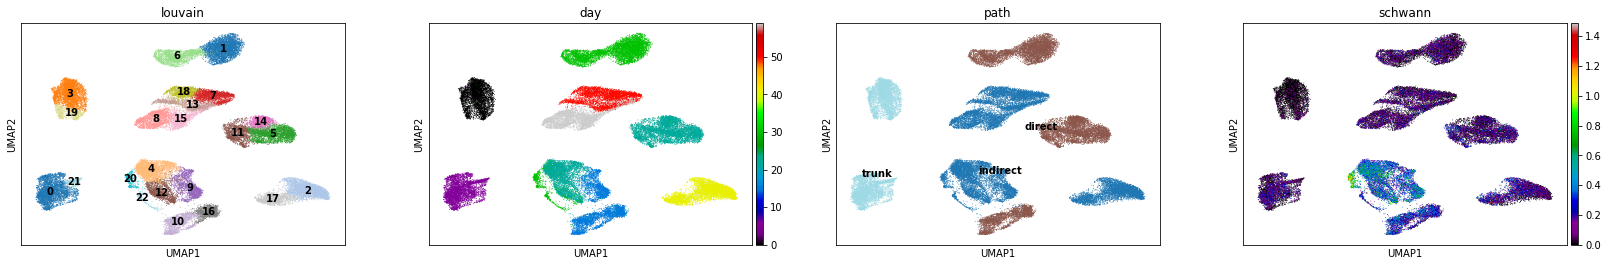

In [8]:
# high resolution
schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']
cat, exp_df = prepare_dataframe(adata_coi,
                     var_names = schwann,
                     groupby = 'louvain')

adata_coi.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1).values
sc.pl.umap(adata_coi, color = ['louvain','day','path','schwann'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)

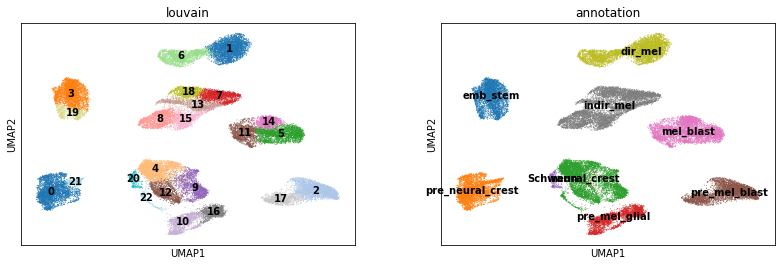

In [57]:
# add annotations
input_adata = adata_coi
cluster_labels = {'7':'indir_mel',
                  '8':'indir_mel',
                  '13':'indir_mel',
                  '15':'indir_mel',
                  '18':'indir_mel',
                  '4':'neural_crest',
                  '9':'neural_crest',
                  '12':'neural_crest',
                  '20':'Schwann',
                  '22':'neural_crest',
                  '1':'dir_mel',
                  '6':'dir_mel',
                  '5':'mel_blast',
                  '11':'mel_blast',
                  '14':'mel_blast',
                  '2':'pre_mel_blast',
                  '17':'pre_mel_blast',
                  '0':'pre_neural_crest',
                  '21':'pre_neural_crest',
                  '3':'emb_stem',
                  '19':'emb_stem',
                  '10':'pre_mel_glial',
                  '16':'pre_mel_glial',
                 }

input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster_labels)
input_adata.obs['annotation'] = (input_adata.obs['annotation']
                                    .astype(str)
                                    .astype(CategoricalDtype(['emb_stem', 
                                                              'pre_neural_crest',
                                                              'neural_crest',
                                                              'pre_mel_glial',
                                                              'Schwann',
                                                              'pre_mel_blast',
                                                              'mel_blast',
                                                              'indir_mel',
                                                              'dir_mel',
                                                             ],ordered=True)))

sc.pl.umap(input_adata, color = ['louvain','annotation'], 
           legend_loc = 'on data', )
# save = 'plot_8.svg')


# cycling score

... storing 'cycling_cell' as categorical


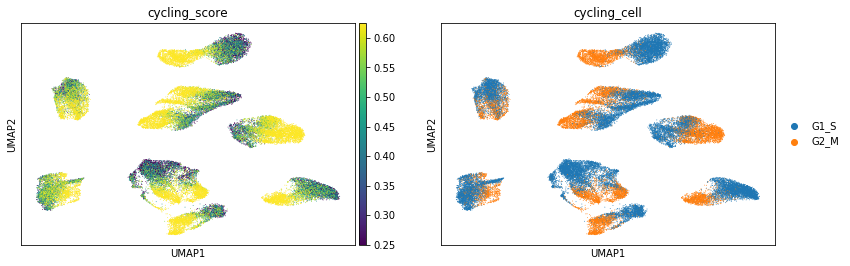

In [58]:
cycling_module = ['TOP2A','CDK1','UBE2C','CDT1']
input_adata = adata_coi
threshold = 60

input_adata.obs['cell'] = input_adata.obs.index.tolist()
input_adata.obs['cell'] = (input_adata
                          .obs['cell']
                          .astype(str)
                          .astype(CategoricalDtype(input_adata.obs['cell'].tolist())))
cat, exp_df = prepare_dataframe(input_adata,
                 var_names = cycling_module,
                 groupby = 'cell')
exp_df = exp_df.rank(pct=True, axis=0, method = 'min') # ranked expression per cell
exp_df = exp_df.rank(pct=True, axis=1, method = 'min') # ranking ranked expression per gene

input_adata.obs['cycling_score'] = exp_df.loc[:,cycling_module].mean(axis=1)
omit_names = (input_adata[input_adata.obs.cycling_score > np.percentile(input_adata.obs.cycling_score.values, 
                                                                        threshold)]
              .obs
              .index
              .tolist()
             )

input_adata.obs['cycling_cell'] = ['G2_M' if x in set(omit_names) else \
                                   'G1_S' for x in input_adata.obs.index]

sc.pl.umap(input_adata, color = ['cycling_score','cycling_cell'])


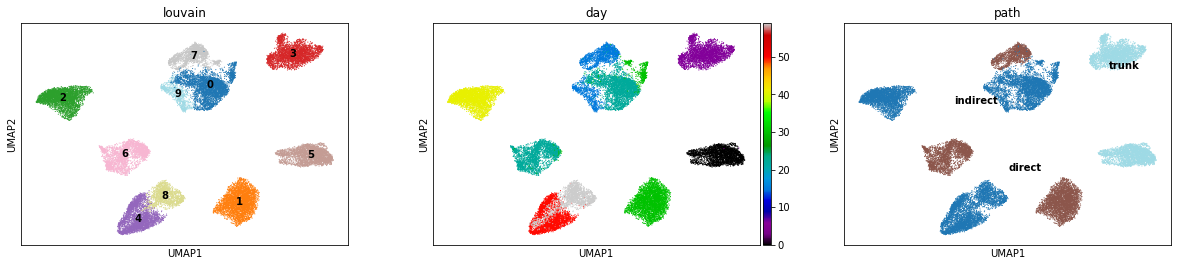

In [61]:
run_me = True
input_adata = adata_coi
coi_idx = input_adata[input_adata.obs['cycling_cell'] == 'G1_S'].obs.index.tolist()

if run_me == True:    
    # UMAP and PCA
    # pca and umap optimization
    n_pcs = 150
    adata_coi_noncyc = sc.pp.log1p(adata_all[[x in coi_idx for x in adata_all.obs.index]], copy=True) # new
    sc.pp.highly_variable_genes(adata_coi_noncyc,min_mean=0.1,max_mean=10,min_disp=0.5) # new
    sc.pp.scale(adata_coi_noncyc) # new
    sc.tl.pca(adata_coi_noncyc, use_highly_variable = True, n_comps=n_pcs, random_state=1) # new
    sc.pp.neighbors(adata_coi_noncyc, n_pcs=n_pcs, n_neighbors = 25, random_state=1) # new
    sc.tl.umap(adata_coi_noncyc, min_dist = 0.5, random_state=1)
    sc.tl.louvain(adata_coi_noncyc, resolution = 0.5, random_state=1)
    sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
                   palette = 'tab20', cmap = 'nipy_spectral',)


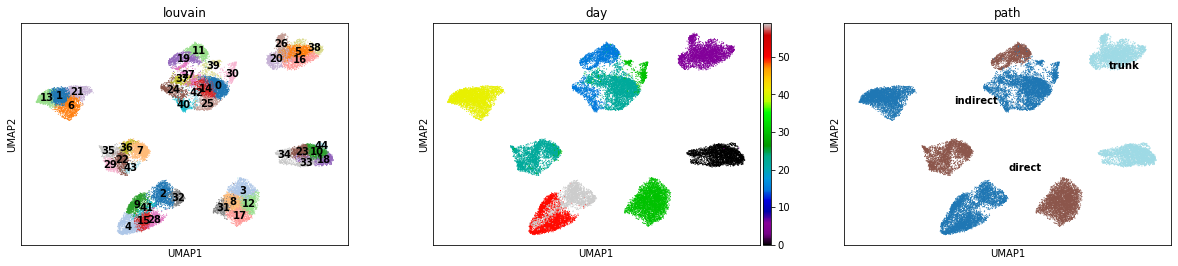

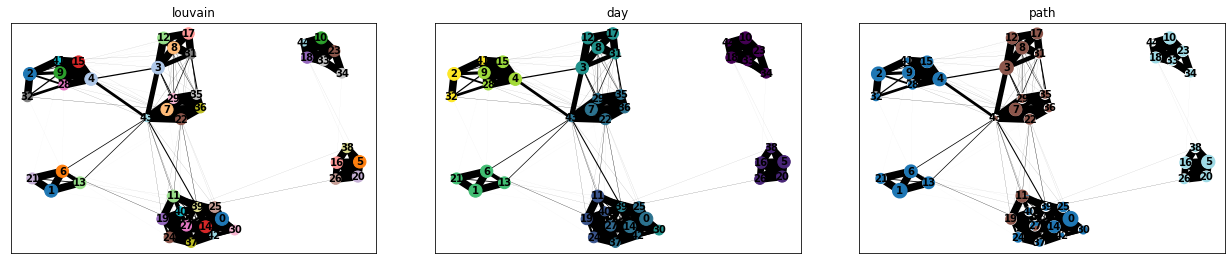

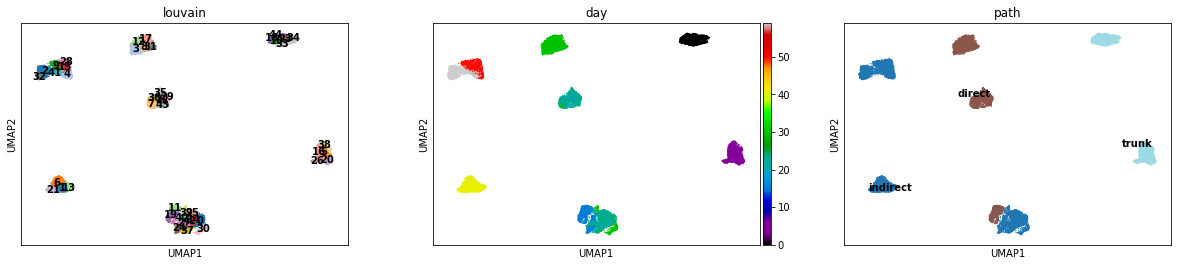

In [62]:
sc.tl.louvain(adata_coi_noncyc, resolution = 5, random_state=1)
sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)
sc.tl.paga(adata_coi_noncyc, groups='louvain')
sc.pl.paga(adata_coi_noncyc, color=['louvain','day','path'],
          threshold=0)
sc.tl.umap(adata_coi_noncyc, min_dist = 0.5, 
           random_state=1, init_pos='paga')
sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)


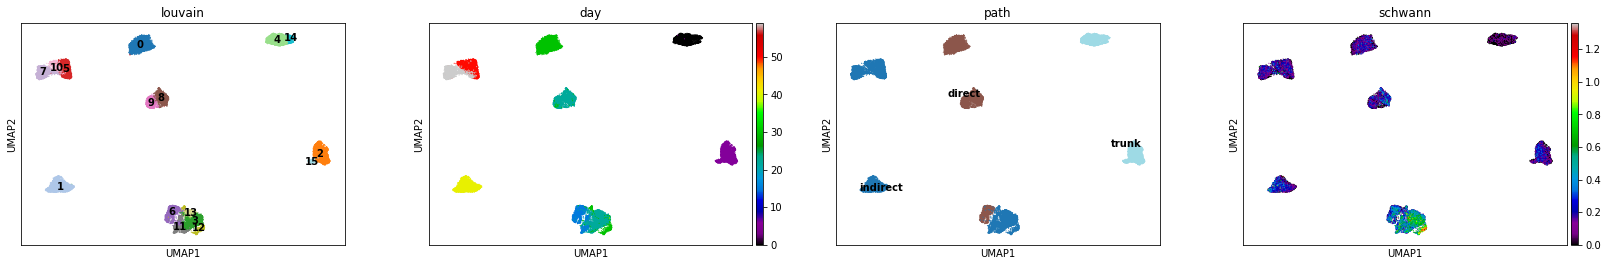

In [67]:
# high resolution
sc.tl.louvain(adata_coi_noncyc, resolution = 1.5, random_state=1)

schwann = ['TGFB1','GDNF','CDH19','TGFBR2','MPZ','GAP43']
cat, exp_df = prepare_dataframe(adata_coi_noncyc,
                     var_names = schwann,
                     groupby = 'louvain')

adata_coi_noncyc.obs['schwann'] = exp_df.loc[:,schwann].mean(axis=1).values
sc.pl.umap(adata_coi_noncyc, color = ['louvain','day','path','schwann'], legend_loc = 'on data', 
               palette = 'tab20', cmap = 'nipy_spectral',)


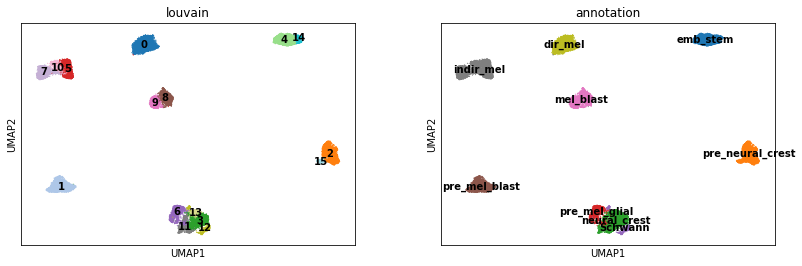

In [68]:
# add annotations
input_adata = adata_coi_noncyc
cluster_labels = {'0':'dir_mel',
                  '1':'pre_mel_blast',
                  '2':'pre_neural_crest',
                  '3':'neural_crest',
                  '4':'emb_stem',
                  '5':'indir_mel',
                  '6':'pre_mel_glial',
                  '7':'indir_mel',
                  '8':'mel_blast',
                  '9':'mel_blast',
                  '10':'indir_mel',
                  '11':'neural_crest',
                  '12':'Schwann',
                  '13':'neural_crest',
                  '14':'emb_stem',
                  '15':'pre_neural_crest',
                 }
input_adata.obs['annotation'] = input_adata.obs['louvain'].map(cluster_labels)
input_adata.obs['annotation'] = (input_adata.obs['annotation']
                                    .astype(str)
                                    .astype(CategoricalDtype(['emb_stem', 
                                                              'pre_neural_crest',
                                                              'neural_crest',
                                                              'pre_mel_glial',
                                                              'Schwann',
                                                              'pre_mel_blast',
                                                              'mel_blast',
                                                              'indir_mel',
                                                              'dir_mel',
                                                             ],ordered=True)))

sc.pl.umap(input_adata, color = ['louvain','annotation'], 
           legend_loc = 'on data',)
# save = 'plot_8.svg')


In [ ]:
# for objname in ['adata_coi_noncyc']:
#     pickle.dump(eval(objname), open( f"{wkdir}/{objname}.p", "wb" ), protocol=4 )
#     syscmd = f'aws s3 cp {wkdir}/{objname}.p s3://{s3dir}/'
#     subprocess.run(syscmd.split(' '))

# PCA

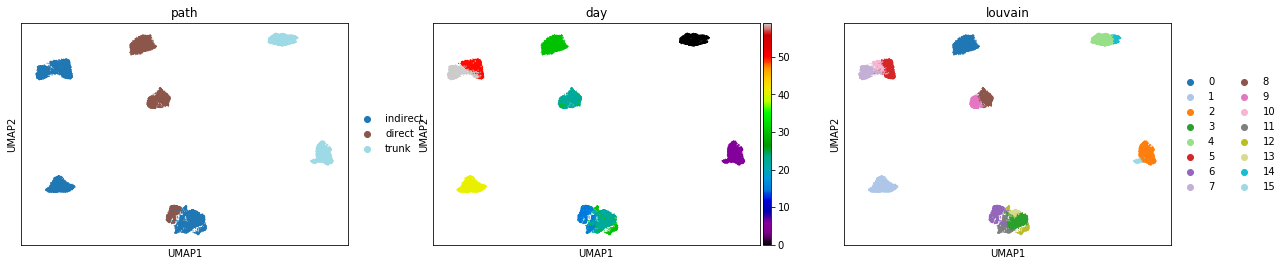

all_paths


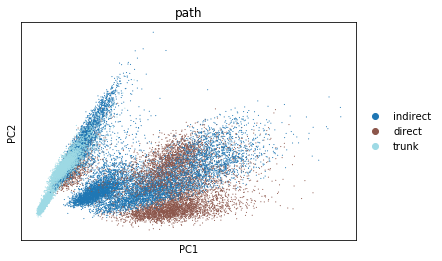

trunk


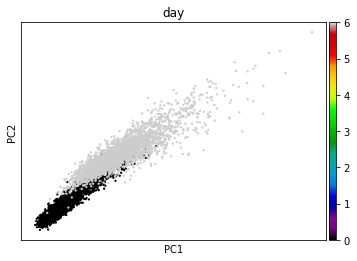

trunk + indirect


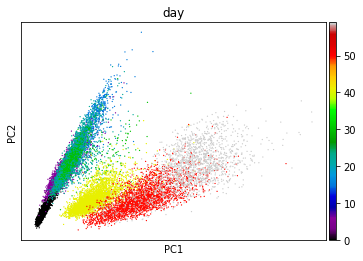

trunk + direct


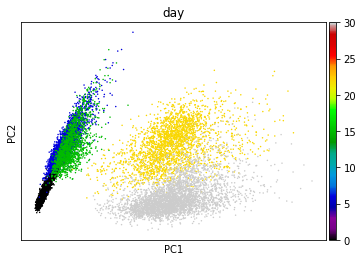

In [69]:
input_adata = adata_coi_noncyc
sc.pl.umap(input_adata, color = ['path', 'day','louvain'], palette = 'tab20', cmap = 'nipy_spectral')
components = ['1,2']

print('all_paths')
sc.pl.pca(input_adata, color = ['path'], components=components, palette = 'tab20', )
#           save = 'plot_9.svg')
print('trunk')
sc.pl.pca(input_adata[input_adata.obs.path == 'trunk'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_10.svg')
print('trunk + indirect')
sc.pl.pca(input_adata[input_adata.obs.path != 'direct'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_11.svg')
print('trunk + direct')
sc.pl.pca(input_adata[input_adata.obs.path != 'indirect'], color = ['day'], 
          components=components, cmap = 'nipy_spectral', )
#           save = 'plot_12.svg')


# Differential expression: path-specific terminally-differentiated

## Bulkized ranked correlation

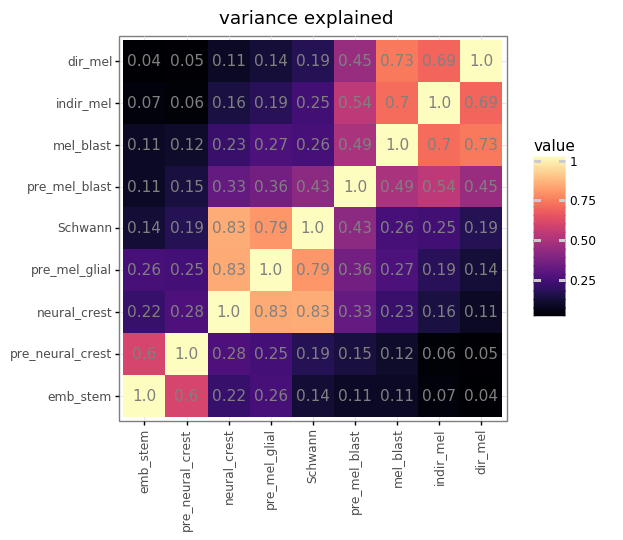

<ggplot: (8768762703403)>


In [70]:
input_adata = adata_coi_noncyc
cat, adata_louvain_df = prepare_dataframe(input_adata,
                                          (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist(),
                                          'annotation')

corr_df = (adata_louvain_df
           .reset_index()
           .groupby('annotation')
           .mean()
           .T)

plot_df = corr_df.corr('spearman')**2
plot_df.columns = plot_df.index.tolist()
plot_df['cluster'] = plot_df.index.tolist()
plot_df = pd.melt(plot_df, id_vars='cluster')
for i in ['cluster','variable']:
    plot_df[i] = (plot_df[i]
                        .astype(str)
                        .astype(CategoricalDtype(['emb_stem', 
                                                              'pre_neural_crest',
                                                              'neural_crest',
                                                              'pre_mel_glial',
                                                              'Schwann',
                                                              'pre_mel_blast',
                                                              'mel_blast',
                                                              'indir_mel',
                                                              'dir_mel',
                                                             ],
                                                 ordered=True)))
plot_df['label'] = [round(x,2) for x in plot_df.value]

plotnine.options.figure_size = (5,5)
p1 = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','variable',fill='value'))
      + geom_text(aes('cluster','variable',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
      + labs(x = '', y = ''))
print(p1)


In [ ]:
# p1.save('/home/ubuntu/data/DL20190312_dish_mel/plot/plot_13.svg', height=8, width=8)

## Analysis of marker genes over developmental time

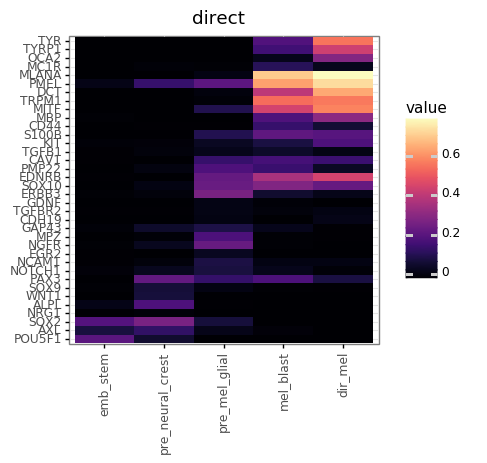

<ggplot: (-9223363268083032874)>


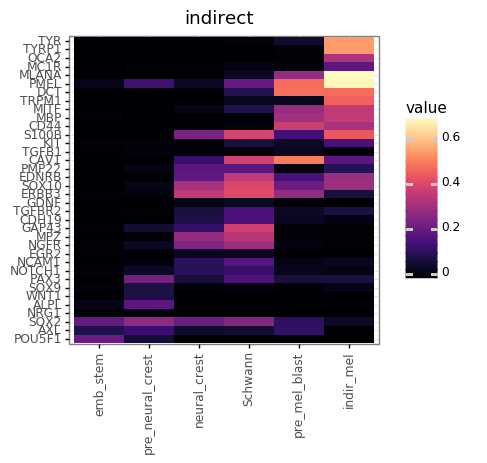

<ggplot: (8768762601999)>


In [52]:
# on means
# ref: https://www.frontiersin.org/articles/10.3389/fnmol.2019.00069/full

input_adata = adata_coi_noncyc
genes = ['POU5F1','AXL','SOX2','NRG1','ALPL','WNT1','SOX9','PAX3',
         'NOTCH1','NCAM1','EGR2','NGFR','MPZ','GAP43',
         'CDH19','TGFBR2','GDNF',
         'ERBB3','SOX10','EDNRB','PMP22','CAV1',
         'TGFB1','KIT','S100B','CD44', 'MBP', 
         'MITF',
         'TRPM1','DCT','PMEL','MLANA','MC1R','OCA2','TYRP1','TYR']
direct_order = ['emb_stem', 
                  'pre_neural_crest',
                  'pre_mel_glial',
                  'mel_blast',
                  'dir_mel',
                 ]
indirect_order = ['emb_stem', 
                  'pre_neural_crest',
                  'neural_crest',
                  'Schwann',
                  'pre_mel_blast',
                  'indir_mel',
                 ]

for idx, grouping in enumerate(['direct', 'indirect']):
    order_list = eval(f'{grouping}_order')
        
    cat, df = prepare_dataframe(input_adata,
                                genes,
                                'annotation')
    df = df.apply(lambda x: min_max_scaler(x.values)) ### test
    df = df.reset_index()
    df['annotation'] = (df['annotation']
                                .astype(str)
                                .astype(CategoricalDtype(order_list,ordered=True)))
    plot_df = pd.melt(df
                       .groupby('annotation')
                       .mean()
                       .reset_index(), id_vars='annotation')
    plot_df['variable'] = (plot_df['variable']
                           .astype(str)
                           .astype(CategoricalDtype(genes, ordered=True))
                          )
    plot_df = plot_df.dropna()
    plotnine.options.figure_size = (4,4)
    p2 = (ggplot(plot_df)
          + theme_bw()
          + theme(axis_text_x = element_text(angle = 90))
          + geom_tile(aes('annotation','variable',fill = 'value'))
          + scale_fill_cmap('magma')
          + labs(x = "", y = "")
          + ggtitle(grouping)
         )
    print(p2)
#     p2.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_{counter}.svg', height=8, width=8)


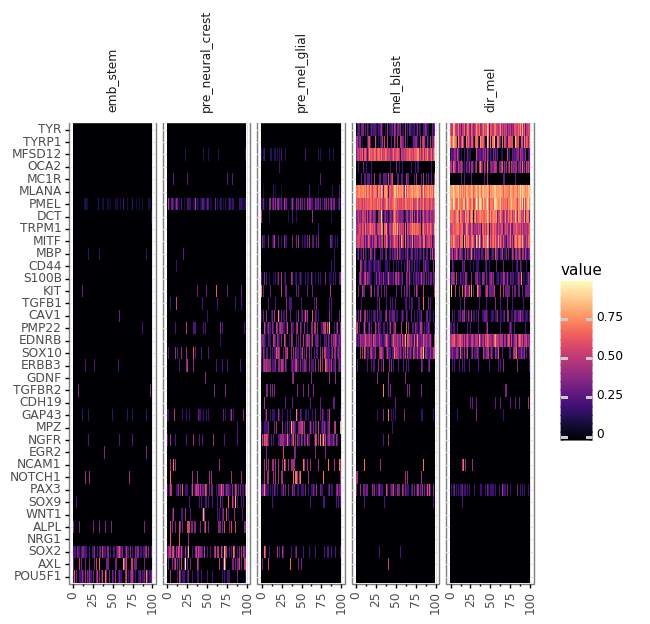

<ggplot: (-9223363268071444655)>


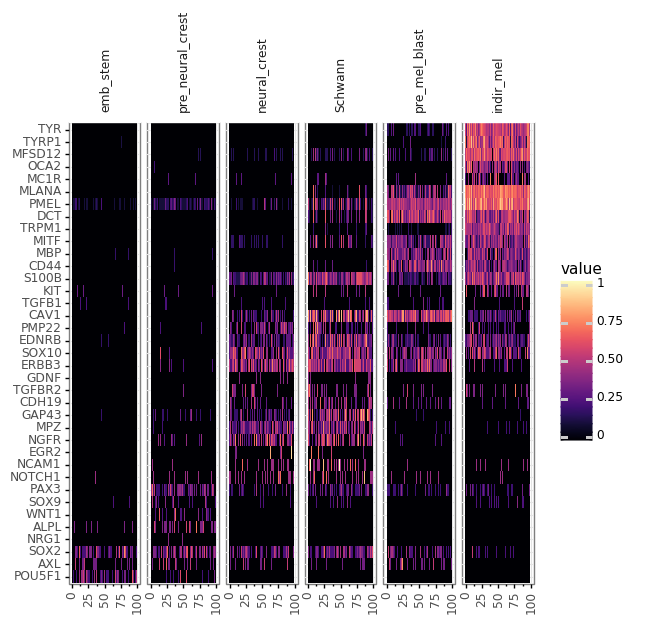

<ggplot: (-9223363268082925564)>


In [45]:
# on single cells
# ref: https://www.frontiersin.org/articles/10.3389/fnmol.2019.00069/full

input_adata = adata_coi_noncyc
n_cells = 100

for idx, grouping in enumerate(['direct', 'indirect']):
    counter = idx + 16
    order_list = eval(f'{grouping}_order') 
        
    cat, df = prepare_dataframe(input_adata,
                                genes,
                                'annotation')
    df = df.apply(lambda x: min_max_scaler(x.values))
    df = df.reset_index()
    df['annotation'] = (df['annotation']
                                .astype(str)
                                .astype(CategoricalDtype(order_list,ordered=True)))
    df_melt = pd.melt((df
                       .groupby('annotation')
                       .apply(lambda x: (x.sample(n_cells)
                                         .assign(idx = lambda x: [i for i in range(len(x))])
                                        )
                             )
                      ), id_vars=['annotation','idx']
                     )
    df_melt['variable'] = (df_melt['variable']
                           .astype(str)
                           .astype(CategoricalDtype(genes, ordered=True))
                          )
    df_melt = df_melt.dropna()

    plotnine.options.figure_size = (6,6)
    p3 = (ggplot(df_melt)
          + theme_bw()
          + theme(axis_text_x = element_text(angle = 90),
                  strip_text_x = element_text(angle = 90, vjust=0),
                  strip_background = element_rect(fill = 'white', color = 'white')
                 )
          + geom_tile(aes('idx','variable',fill = 'value'))
          + scale_fill_cmap('magma')
          + labs(x = "", y = "")
          + facet_grid('.~annotation')
#           + ggtitle(grouping)
         )
    print(p3)
#     p3.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/{grouping}_plot_{counter}.svg', height=8, width=8)


## Analysis of cell type proportions over developmental time
INCLUDES CYCLING CELLS IN PROPORTION CALCULATION!!!

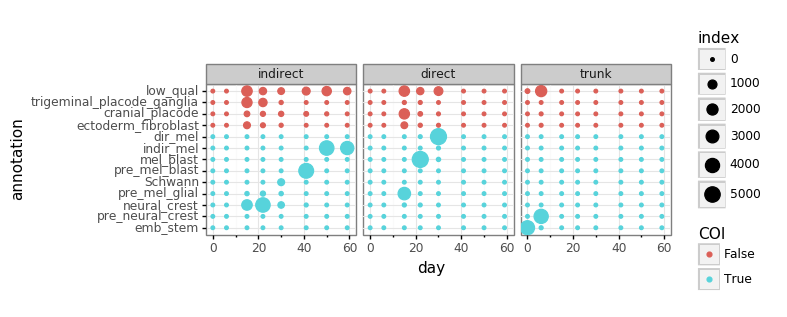

<ggplot: (-9223363268083409243)>


In [118]:
adata_1 = (all_cells_adata[[not x.endswith('COI') for x in all_cells_adata.obs.annotation]]
           .obs
           .loc[:,['annotation','day','path']]
           .reset_index()
          )
adata_2 = (adata_coi
           .obs
           .loc[:,['annotation','day','path']]
           .reset_index()
          )
merge_adata = adata_1.append(adata_2)
merge_adata['annotation'] = [x if not x.startswith('low_') \
                             else 'low_qual'
                             for x in merge_adata['annotation']]
merge_adata = (merge_adata
             .groupby(['path','day','annotation'])
             .count()
             .replace(np.nan,0)
             .astype(int)
             .reset_index()
            )
merge_adata['annotation'] = (merge_adata['annotation']
                          .astype(str)
                          .astype(CategoricalDtype(['emb_stem', 
                                                  'pre_neural_crest',
                                                  'neural_crest',
                                                  'pre_mel_glial',
                                                  'Schwann',
                                                  'pre_mel_blast',
                                                  'mel_blast',
                                                  'indir_mel',
                                                  'dir_mel',
                                                    'ectoderm_fibroblast',
                                                    'cranial_placode',
                                                    'trigeminal_placode_ganglia',
                                                    'low_qual'
                                                   ],
                                                   ordered = True
                                                  ))
                         )
cois = ['emb_stem', 
          'pre_neural_crest',
          'neural_crest',
          'pre_mel_glial',
          'Schwann',
          'pre_mel_blast',
          'mel_blast',
          'indir_mel',
          'dir_mel',
       ]
merge_adata['COI'] = [x in cois for x in merge_adata['annotation']]

plotnine.options.figure_size = (6,6)
p4 = (ggplot(merge_adata)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_point(aes('day','annotation',size ='index',color='COI'))
      + xlim([0,60])
      + facet_wrap('~path')
     )
print(p4)

In [117]:
set(merge_adata.path)

{'indirect'}

In [ ]:
master_df = pd.DataFrame()
for i in ['indirect','direct']:
    if i == 'direct':
        path = 'indirect'
    else:
        path = 'direct'
        
    input_adata1 = adata_all[adata_all.obs.path != i]
    input_adata2 = adata_coi[adata_coi.obs.path != i]

    df1 = input_adata1.obs.loc[:, ['annotation','day','path']].rename(columns = {'path':'n_cells'})
    df1['annotation'] = ['low_quality' if x.startswith('low_quality') else x for x in df1.annotation]
    df1 = df1[[not x.endswith('COI') for x in df1.annotation]]
    df1['COI'] = False
    
    df2 = input_adata2.obs.loc[:, ['detailed_annotation','day','path']].rename(columns = {'path':'n_cells',
                                                                                          'detailed_annotation':'annotation' 
                                                                                         })
    df2['COI'] = True
    
    merged_df = df1.append(df2)
    merged_df['annotation'] = (merged_df['annotation']
                          .astype(str)
                          .astype(CategoricalDtype(trunk_order+direct_order+indirect_order+
                                                   ['ectoderm_fibroblast',
                                                    'cranial_placode',
                                                    'trigeminal_placode_ganglia',
                                                    'low_quality'
                                                   ],
                                                   ordered = True
                                                  ))
                         )
    merged_df = merged_df.groupby(['day','annotation','COI']).count()
    merged_df = merged_df.reset_index().dropna()
    merged_df['n_cells'] = merged_df.groupby('day')['n_cells'].apply(lambda x: x/np.sum(x))
    merged_df['path'] = path
    master_df = master_df.append(merged_df)

plotnine.options.figure_size = (6,6)
p4 = (ggplot(master_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_point(aes('day','annotation',size ='n_cells',color='COI'))
      + xlim([0,60])
      + facet_wrap('~path')
     )
print(p4)
# p4.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_18.svg', height=8, width=8)


## Ranked location test

In [ ]:
n_print = 10
input_adata = adata_coi_noncyc
ref1_cluster = 'indir_melanocyte'
ref2_cluster = 'dir_melanocyte'

ref1_adata = input_adata[input_adata.obs.detailed_annotation == ref1_cluster]
ref2_adata = input_adata[input_adata.obs.detailed_annotation == ref2_cluster]
genes = (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()

cat, ref1_df = prepare_dataframe(ref1_adata,
                                         genes,
                                        'path')
ref1_df = ref1_df.transform(lambda x: np.log1p(x))
cat, ref2_df = prepare_dataframe(ref2_adata,
                                         genes,
                                        'path')
ref2_df = ref2_df.transform(lambda x: np.log1p(x))

# bulkized correlation
stat, pval = stats.spearmanr(ref1_df.mean().values, ref2_df.mean().values)
print('variance explained:', stat**2)
plot_df = pd.DataFrame({ref1_cluster: ref1_df.mean().values,
                        ref2_cluster: ref2_df.mean().values
                       })

plotnine.options.figure_size = (4,4)
p5 = (ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes(ref1_cluster, ref2_cluster))
      + scale_y_log10()
      + scale_x_log10()
     )
print(p5)
p5.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_19.svg', height=8, width=8)


# location test
for i in ['greater', 'less']:
    print(f'{ref1_cluster} {i} than {ref2_cluster}:')

    frac = 1
    n_uncert = 1
    while n_uncert > 0:
        test_df1 = ref1_df.sample(frac=frac).rank(pct=True, axis = 1, method = 'min')
        test_df2 = ref2_df.sample(frac=frac).rank(pct=True, axis = 1, method = 'min')

        stat_pval_tuple = parallel_mwu(genes, 
                                   test_df1, 
                                   test_df2, 
                                   i, 
                                   15)
        stat_list = stat_pval_tuple[0]
        pval_list = stat_pval_tuple[1]
        results_df = pd.DataFrame({'gene':genes,
                                 'stat_1':stat_list,
                                 'pval_1':pval_list,
                                })
        results_df['frac'] = frac
        n_uncert = sum(results_df['pval_1'] == 0)
        frac /= 2
    print(f'downsample fraction: {frac}')

    display(results_df.dropna().sort_values('pval_1').head(n_print))


In [ ]:
def geneset_lookup(glist, 
                   outdir = '/home/ubuntu/data/enrichr_kegg',
                   gene_sets = ['KEGG_2016',
                                'GO_Molecular_Function_2018',
                                'GO_Biological_Process_2018',
                                'GO_Cellular_Component_2018',
                                'WikiPathways_2016'
                                ]
                  ):
    import gseapy as gp
    
    # API call
    enr = gp.enrichr(gene_list = glist,
                            description='test',
                            gene_sets=gene_sets,
                            outdir=f'{outdir}', 
                            cutoff=0.5)

    # output results
    return enr.results.sort_values('Adjusted P-value')

In [ ]:
geneset_lookup(results_df.dropna().sort_values('pval_1').head(25).gene.tolist())

In [ ]:
gene = 'NMRK2'
input_adata = adata_coi

sc.pl.umap(input_adata, color = ['detailed_annotation'] + [gene], 
           cmap='nipy_spectral', palette = 'tab20', legend_loc = 'on data')

plot_df = pd.DataFrame({'value':ref1_df[gene].values,
                        'variable':ref1_cluster
                       }).append(pd.DataFrame({'value':ref2_df[gene].values,
                                               'variable':ref2_cluster
                                              }))

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_boxplot(aes('variable','value', color = 'variable'))
      + geom_jitter(aes('variable','value', color = 'variable'), alpha = 0.01)
      + labs(y = 'log1p counts')
     )

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Comparison to primary melanocytes

## Bulkized ranked correlation

In [ ]:
## read in adata with fetal melanocytes = full_adata
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'
for file in ['full_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

input_adata = adata_coi_noncyc

# bulk-ize terminal direct and indirect...spearman correlation to bulkized fetal
genes = list(set(full_adata.var_names) & set((input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()))

# create expression vector for COI cluster
cat, coi_df = prepare_dataframe(input_adata,
                                genes,
                                'detailed_annotation'
                               )
coi_df = (coi_df
          .transform(lambda x: np.log1p(x))
          .reset_index()
          .groupby('detailed_annotation')
          .mean()
          .reset_index()
         )
# create expression vector for primary dev_subtypes
cat, primary_df = prepare_dataframe(full_adata,
                                genes,
                                'class_1'
                               )
primary_df = primary_df[[x in ['mel','msc','fibroblast'] for x in primary_df.index]]
primary_df = (primary_df
              .transform(lambda x: np.log1p(x)))
primary_df = primary_df.reset_index()
primary_df['class_1'] = primary_df['class_1'].astype(str)
primary_df = (primary_df
              .groupby('class_1')
              .mean()
              .reset_index()
              .rename(columns = {'class_1':'detailed_annotation'})
             )

compare_df = coi_df.append(primary_df).set_index('detailed_annotation')
compare_df = compare_df.T
plot_df = compare_df.corr('spearman') ** 2
plot_df.columns = plot_df.index.tolist()
plot_df['cluster'] = plot_df.index.tolist()
plot_df = pd.melt(plot_df, id_vars='cluster')
plot_df['label'] = [round(x,2) for x in plot_df.value]

cluster_order = trunk_order+direct_order+indirect_order+['mel','msc','fibroblast']

plot_df['cluster'] = (plot_df['cluster']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )
plot_df['variable'] = (plot_df['variable']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )

plotnine.options.figure_size = (7,7)
p6 = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','variable',fill='value'))
      + geom_text(aes('cluster','variable',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
      + labs(x = '', y = '')
     )
print(p6)
# p6.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_20.svg', height=8, width=8)

# DEV: Cancer correlation

In [ ]:
input_adata = adata_coi

# download raw data from s3
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

# import data from s3
for file in ['acraldata.MvA.counts.csv']:
    ! aws s3 cp s3://{s3dir}/{file} {wkdir}/

cell_line_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/acraldata.MvA.counts.csv',
                           index_col=0)
cell_line_df.columns = [x.replace('-','_') for x in cell_line_df.columns]
cell_line_df = (cell_line_df.set_index(pd.Index([x.split(' ')[0] for x in cell_line_df.index]))
                .sort_index())
cell_line_df = cell_line_df.apply(np.log1p)
genes = list(set(cell_line_df.index) & set((input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()))
cell_line_df = cell_line_df[[x in genes for x in cell_line_df.index]]
cell_line_df = cell_line_df[~cell_line_df.index.duplicated(keep='first')]
cell_line_df = cell_line_df.T
cell_line_df['cancer_origin'] = ['CMM' if x.startswith('1205LU') or x.startswith('SKMEL') else 'AM' for x in cell_line_df.index]
cell_line_df = cell_line_df.set_index('cancer_origin')
cell_line_df = (cell_line_df
                .reset_index()
                .groupby('cancer_origin')
                .mean()
                .reset_index()
                .rename(columns = {'cancer_origin':'detailed_annotation'})
               )

cat, coi_df = prepare_dataframe(input_adata,
                                genes,
                                groupby = 'detailed_annotation'
                               )
coi_df = (coi_df
          .transform(lambda x: np.log1p(x))
          .reset_index()
          .groupby('detailed_annotation')
          .mean()
          .reset_index()
         )

compare_df = coi_df.append(cell_line_df).set_index('detailed_annotation')
compare_df = compare_df.T
plot_df = compare_df.corr('spearman') ** 2
plot_df.columns = plot_df.index.tolist()
plot_df['cluster'] = plot_df.index.tolist()
plot_df = pd.melt(plot_df, id_vars='cluster')
plot_df['label'] = [round(x,2) for x in plot_df.value]

cluster_order = trunk_order+direct_order+indirect_order+['AM',
                                                         'CMM']

plot_df['cluster'] = (plot_df['cluster']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )
plot_df['variable'] = (plot_df['variable']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )

plotnine.options.figure_size = (7,7)
p7 = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','variable',fill='value'))
      + geom_text(aes('cluster','variable',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
      + labs(x = '', y = '')
     )
print(p7)
p7.save(f'/home/ubuntu/data/DL20190312_dish_mel/plot/plot_21.svg', height=8, width=8)

# DEV: single-cell melanoma correlation
- fix correlations to use only highly variable genes

In [ ]:
input_adata = adata_coi
high_var_genes = (input_adata.var['highly_variable'][input_adata.var['highly_variable'] == True]).index.tolist()

sc_mel_df = pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/cancer_ext_data/GSE72056_melanoma_single_cell_revised_v2.txt',
           sep = '\t')

sc_mel_counts = (sc_mel_df.iloc[3:,:]
                 .rename(columns = {'Cell':'gene'})
                 .set_index('gene')
                 .T
                )
# add patient annotations
sc_mel_counts['cancer_patient'] = ['mel_{}'.format(int(x)) for x in sc_mel_df.iloc[0,1:]]
# remove non-malignant cells
sc_mel_counts = sc_mel_counts[sc_mel_df.iloc[1,1:] == 2]
# filter based on Fig1C constituents from paper
# mel_cell_id = [53,58,60,72,74,78,79,80,81,84,88,89,94]
# sc_mel_counts = sc_mel_counts[[int(x.split('_')[1]) in mel_cell_id for x in sc_mel_counts.cancer_patient]]
# groupby and mean
sc_mel_counts = (sc_mel_counts.groupby('cancer_patient')
                 .mean()
                 .reset_index()
                 .rename(columns = {'cancer_patient':'detailed_annotation'})
                )
sc_mel_counts = sc_mel_counts.iloc[:,[idx for idx,x in enumerate(sc_mel_counts.columns.duplicated(keep='first')) if x == False]]
genes = list(set([x for x in sc_mel_counts.columns if x in high_var_genes]))
sc_mel_counts = sc_mel_counts.loc[:, ['detailed_annotation']+genes]

cat, coi_df = prepare_dataframe(input_adata,
                                genes,
                                groupby = 'detailed_annotation'
                               )
coi_df = (coi_df
          .transform(lambda x: np.log1p(x))
          .reset_index()
          .groupby('detailed_annotation')
          .mean()
          .reset_index()
         )

compare_df = sc_mel_counts.append(coi_df)
compare_df = (compare_df
              .set_index('detailed_annotation')
              .T)


In [ ]:
plot_df = compare_df.corr('spearman') ** 2
plot_df.columns = plot_df.index.tolist()
plot_df['cluster'] = plot_df.index.tolist()
plot_df = pd.melt(plot_df, id_vars='cluster')
plot_df['label'] = [round(x,2) for x in plot_df.value]

cluster_order = trunk_order+direct_order+indirect_order+sc_mel_counts.detailed_annotation.tolist()

plot_df['cluster'] = (plot_df['cluster']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )
plot_df['variable'] = (plot_df['variable']
                      .astype(str)
                      .astype(CategoricalDtype(cluster_order, ordered=True))
                     )

plotnine.options.figure_size = (12,12)
p8 = (ggplot(plot_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90))
      + geom_tile(aes('cluster','variable',fill='value'))
      + geom_text(aes('cluster','variable',label='label'), color = 'grey')
      + scale_fill_cmap('magma')
      + ggtitle('variance explained')
      + labs(x = '', y = '')
     )
print(p8)


# DEV: linear regression

In [ ]:
# class labels
compare_df.columns

In [ ]:
# linear regression between cancer
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score

def regress(x, y):
    # requires 1D array of shape (-1, 1)
    # returns fit and residuals residuals
    
    # Model initialization
    regression_model =  LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(x, y)
    # Predict
    y_predicted = regression_model.predict(x).reshape((-1,1))
    y_residuals = ref2_vec - y_predicted
    
    return y_predicted.flatten(), y_residuals.flatten()
    

In [ ]:
n_print = 10

ref1 = 'mel_84'
ref2 = 'indir_melanocyte'
ref1_vec = compare_df[ref1].values.reshape(-1, 1)
ref2_vec = compare_df[ref2].values.reshape(-1, 1)
geneOI = 'SPP1'

y_predicted, y_residuals = regress(ref1_vec, ref2_vec)

plot_df = pd.DataFrame({ref1:ref1_vec.flatten(),
                        ref2:ref2_vec.flatten(),
                        'fitted':y_predicted.flatten(),
                        'resid':y_residuals.flatten()
                       })
plot_df['group'] = 'group'
plot_df['sq_resid'] = plot_df['resid'] ** 2
plot_df['norm_resid'] = plot_df['resid']/plot_df['fitted']
plot_df['gene'] = compare_df.index.values
plot_df['GOI'] = [x == geneOI for x in plot_df['gene']]

plot_df_slice = plot_df.sort_values('sq_resid', ascending=False).head(n_print)
plot_df_slice['idx'] = [x for x in range(len(plot_df_slice))]

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
      + theme_bw()
      + geom_point(aes(ref1, ref2), alpha = 0.1)
      + geom_point(plot_df[plot_df['GOI'] == True], aes(ref1, ref2), color = 'red', shape = 'x')
      + geom_line(aes(ref1, 'fitted', group='group'), color = 'red')
      + geom_label(plot_df_slice, 
                  aes(ref1, ref2, label = 'idx'), color = 'red', size = 7)
#       + scale_y_log10()
#       + scale_x_log10()
     )
display(plot_df_slice)

print(ggplot(plot_df)
      + theme_bw()
      + geom_bin2d(aes(ref1, 'norm_resid', group='group'))
     )

print('residuals histogram')
print(plot_df['resid'].hist(bins = 50))


In [ ]:
gene = plot_df_slice.gene.tolist()
out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

In [ ]:
gene = 'IFITM1'
sc.pl.umap(input_adata, color = ['detailed_annotation']+[gene], cmap = 'nipy_spectral', ncols = 1)
out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


## 3-way comparison

In [ ]:
# 3-way correlation analysis
ref1 = 'dir_melanocyte'
ref2 = 'indir_melanocyte'
ref3 = 'AM'
input_df = 'compare_df'

for idx, ref in enumerate([ref1, ref2, ref3]):
    counter = idx+1
    exec(f'ref{counter}_vec = {input_df}["{ref}"].values.reshape(-1, 1)')

# axis1 = dir vs indir
y1_predicted, y1_residuals = regress(ref1_vec, ref2_vec)

# axis2 = dir vs outside
y2_predicted, y2_residuals = regress(ref1_vec, ref3_vec)

# axis3 = indir vs outside
y3_predicted, y3_residuals = regress(ref2_vec, ref3_vec)

# df of z-scores
compare_3way = pd.DataFrame({'dir_vs_indir':(y1_residuals - np.mean(y1_residuals))/np.std(y1_residuals),
                            'dir_vs_outside':(y2_residuals - np.mean(y2_residuals))/np.std(y2_residuals),
                            'indir_vs_outside':(y3_residuals - np.mean(y3_residuals))/np.std(y3_residuals),
                            })
compare_3way['gene'] = eval(input_df).index.values
compare_3way['specificity'] = [ref1 if x < 0 else ref2 if x > 0 else 'equal' for x in compare_3way.dir_vs_indir]
compare_3way['sq_diff'] =  (compare_3way.indir_vs_outside - compare_3way.dir_vs_outside) ** 2
compare_3way = pd.melt(compare_3way, id_vars=['dir_vs_indir','gene','specificity','sq_diff'])
compare_3way['match'] =  ['dir' if (x.startswith('dir') and y.startswith('dir')) else \
                          'indir' if (x.startswith('indir') and y.startswith('indir')) else \
                          'mismatch' \
                          for x,y in zip(compare_3way.specificity, compare_3way.variable)]
compare_3way['value'] = np.abs(compare_3way['value'])


In [ ]:
# filter genes for which dir or indir exhibit low residuals against cancer
z_cutoff = 0.2
gene_cutoff = compare_3way[[x == 'mismatch' and y < z_cutoff \
                            for x,y in zip(compare_3way.match, compare_3way.value)]]['gene'].tolist()
compare_3way['pass'] = [x in gene_cutoff for x in compare_3way['gene']]

compare_3way[compare_3way['pass'] == True].sort_values('sq_diff', ascending = False)


In [ ]:

ref1 = 'dir_melanocyte'
ref2 = 'indir_melanocyte'
ref3 = 'AM'
input_df = 'compare_df'

for idx, ref in enumerate([ref1, ref2, ref3]):
    counter = idx+1
    exec(f'ref{counter}_vec = {input_df}["{ref}"].values.reshape(-1, 1)')

scatter_3way = pd.DataFrame({ref1:ref1_vec.flatten(),
                             ref2:ref2_vec.flatten(),
                             ref3:ref3_vec.flatten(),
                            })
scatter_3way['gene'] = eval(input_df).index.values
scatter_3way = pd.melt(scatter_3way, id_vars='gene')
scatter_3way = pd.merge(scatter_3way,scatter_3way,'inner','gene')
scatter_3way = scatter_3way[[(x,y) in [x for x in combinations([ref1,ref2,ref3] ,2)] \
                              for x,y in zip(scatter_3way.variable_x, scatter_3way.variable_y)]]
scatter_3way['group'] = [f'{x}__{y}' for x,y in zip(scatter_3way.variable_x, scatter_3way.variable_y)]


In [ ]:
geneOI = 'S100B'

ref1 = 'value_x'
ref2 = 'value_y'
ref1_lab = 'variable_x'
ref2_lab = 'variable_y'
scatter_3way['GOI'] = [x == geneOI for x in scatter_3way['gene']]

plotnine.options.figure_size = (6,6)
print(ggplot(scatter_3way)
      + theme_bw()
      + theme(aspect_ratio = 1,
              panel_spacing_x = 0.3
             )
      + geom_point(aes(ref1, ref2), alpha = 0.1)
      + geom_point(scatter_3way[scatter_3way['GOI'] == True], aes(ref1, ref2), color = 'red', shape = 'x')
      + stat_smooth(aes(ref1, ref2), method='lm', color = 'red')
      + labs(x = ref1_lab, y = ref2_lab)
      + facet_grid('variable_y~variable_x', scales = 'free')
     )


# DEV: velocyto

In [ ]:
import loompy
import os
import scvelo as scv

In [ ]:
run = False

filedir = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/'
files = [''.join([filedir,x]) for x in os.listdir(filedir) if (x.endswith('.loom') and x != 'merged.loom')]
for x in files:
    print(x)

filename = '/home/ubuntu/data/DL20190312_dish_mel/velocyto/merged.loom'
if run == True:
    loompy.combine(files,filename,"Accession")


In [ ]:
set(adata_all.obs.annotation)

In [ ]:
adata = scv.read(filename, cache=True)
adata_velo_merge = scv.utils.merge(adata_all[adata_all.obs.path == 'direct'], adata)
basis = 'umap'

scv.pp.filter_and_normalize(adata_velo_merge)
scv.pp.moments(adata_velo_merge)
scv.tl.velocity(adata_velo_merge)
scv.tl.velocity_graph(adata_velo_merge)
scv.tl.velocity_embedding(adata_velo_merge, basis=basis)


In [ ]:
component = '1,2'
scv.pl.velocity_embedding_grid(adata_velo_merge, 
                               basis=basis, 
                               figsize = (10,10),
                               components = component,
                               color = ['cycling_score'],
                               color_map = 'nipy_spectral',
                               ncols = 2
                                  )
